## Завдання.  

Використовуючи бібліотеку PyTorch, створіть генеративно-змагальну мережу (GAN) для генерації зображень цифр MNIST.
1) Завантажте набір даних MNIST з використанням torchvision.datasets. 
2) Створіть генератор, який приймає на вхід випадковий вектор з шумом та генерує зображення цифр MNIST.
3) Створіть дискримінатор, який приймає на вхід зображення цифр MNIST та визначає, чи є це реальне зображення чи згенероване генератором.
4) Обидві моделі повинні мати декілька шарів зі зменшенням розмірності зображення, використовуючи згортувальні та пулінгові шари.
5) Навчіть моделі генерувати нові зображення цифр MNIST, використовуючи взаємодію генератора та дискримінатора з використанням функції втрат GAN (adversarial loss).
6) Після навчання, виведіть кілька згенерованих зображень та порівняйте їх з оригінальними зображеннями з набору даних MNIST.


In [18]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

matplotlib.style.use('ggplot')

### Set parametrs

In [2]:
# learning parameters
batch_size = 512
epochs = 60
start = 0
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load data

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

to_pil_image = transforms.ToPILImage()

In [4]:
train_data = datasets.FashionMNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

### Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)        

### Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

### Create NN

In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [9]:
# loss function
criterion = nn.BCELoss()

In [10]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [11]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [12]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [13]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [14]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)


    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

In [15]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss  

In [16]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [43]:
# generator.train()
# discriminator.train()

### Continue training, load G & D models, set epochs

In [34]:
# add_epochs = 30
# generator = Generator(nz).to(device)
# generator.load_state_dict(torch.load('generator.pth')) 
# discriminator = Discriminator().to(device)
# discriminator.load_state_dict(torch.load('discriminator.pth'))

# df = pd.read_csv('outputs/g_d_losses.csv')
# df = pd.read_csv('outputs/g_d_losses.csv')
# losses_g = list(df['Generator_loss'])
# losses_d = list(df['Discriminator_loss'])
# start = len(df)
# epochs = start + add_epochs

### Train NN

In [47]:
for epoch in range(start, epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g.detach().numpy())
    losses_d.append(epoch_loss_d.detach().numpy())    
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
print('DONE TRAINING')    

Epoch 91 of 92


118it [08:37,  4.39s/it]                         


Generator loss: 2.66163874, Discriminator loss: 0.65785772
Epoch 92 of 92


118it [08:36,  4.37s/it]                         

Generator loss: 2.66755843, Discriminator loss: 0.66107339
DONE TRAINING


### Save G & D models

In [48]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

### Save gif, plots and losses

In [50]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

In [51]:
df_loss = pd.DataFrame({'Generator_loss': losses_g,
                        'Discriminator_loss': losses_d})
df_loss.to_csv('outputs/g_d_losses.csv', index=False)

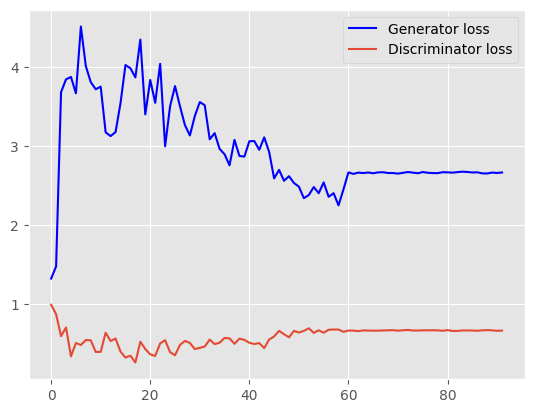

In [52]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss', c='b')
plt.plot(losses_d, label='Discriminator loss')
plt.legend()
# plt.savefig('outputs/loss_g.png')
# plt.figure()

# plt.legend()
plt.savefig('outputs/loss.png')

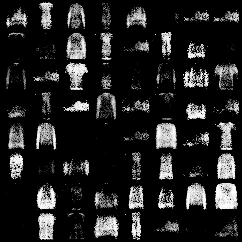

In [53]:
from PIL import Image, ImageEnhance
filename = f"outputs/gen_img{epochs-1}.png"
image = Image.open(filename)
display(image)

### Висновок:  
Нажаль, не вдалося сгенерувати чітких зображень цифр.   
Функціїї втрат генератора і діскримінатора стабілізувались і прогрес в навчанні зупинився.
Всього було прораховано 92 епохи.